In [6]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras import layers,models

In [8]:
import os
import cv2
import numpy as np
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
from tensorflow.keras import backend as k

In [9]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [10]:
epochs =50
INIT_LR = 1e-3
batch_size = 1000
default_image_size = tuple((32, 32))
#image_size = 0
width=32
height=32
depth=3
train_dir=r"C:\Users\Glau\Desktop\marine\Augmentation\Train"
valid_dir=r"C:\Users\Glau\Desktop\marine\Augmentation\Test"
train_folder=listdir(train_dir)
valid_folder=listdir(valid_dir)

In [11]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
callbacks = MyCustomCallback()

In [13]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Amphidinium ...
processing Chatonella ...
processing Cochlodinium ...
processing Gymnodinium catenatum ...
processing Karenia ...
processing Lyngbya ...
processing Ostreopsis ...
processing Prymnesium parvum ...
processing Pseudo-nitzschia ...
processing Tolypothrix conglutinata ...
[INFO] Image loading completed


In [14]:
print(len(train_image_label))

80000


In [15]:
valid_image_list, valid_image_label= [], []
for disease_folder in valid_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{valid_dir}/{disease_folder}")
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]: 
        image_directory = f"{valid_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".TIFF") == True:
            valid_image_list.append(convert_image_to_array(image_directory))
            valid_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Amphidinium ...
processing Chatonella ...
processing Cochlodinium ...
processing Gymnodinium catenatum ...
processing Karenia ...
processing Lyngbya ...
processing Ostreopsis ...
processing Prymnesium parvum ...
processing Pseudo-nitzschia ...
processing Tolypothrix conglutinata ...
[INFO] Image loading completed


In [16]:
print(len(valid_image_label))

20000


In [17]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_marine10.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [18]:
print(n_classes)

10


In [19]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0
np_valid_image_list = np.array(valid_image_list, dtype=np.float32) / 255.0

In [20]:
def identity_block(X,f,filters,stage,block):
    #defining name basis
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    #Retrieve filters
    F1,F2,F3=filters
    #save the input value. we will need this later to add back to main path
    X_shortcut=X
    #First component of main path
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)
    
    #second component of main path
    #X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    #X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    #X=Activation('relu')(X)
    #third component of main path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    # Final step : Add shortcut value to main path and pass it through RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X
    

In [21]:
def convolutional_block(X,f,filters,stage,block,s=2):
    #defining name basis
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    #Retrieve filters
    F1,F2,F3=filters
    #save the input value. we will need this later to add back to main path
    X_shortcut=X
    #First component of main path
    X=Conv2D(filters=F1,kernel_size= (1,1), strides=(s,s),name=conv_name_base +'2a',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X=Activation('relu')(X)
    
    #second component of main path
   # X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base +'2b',kernel_initializer=glorot_uniform(seed=0))(X)
    #X=BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    #X=Activation('relu')(X)
    #third component of main path
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    #Shortcut path
    X_shortcut=Conv2D(F3,kernel_size=(1,1),strides=(1,1),name=conv_name_base+'1',kernel_initializer=glorot_uniform(seed=0))(X)
    X_shortcut=BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)
     #Final step : Add shortcut value to main path and pass it through RELU activation
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    return X

In [23]:
def ResNet50(input_shape=(32,32,3),classes=10):
    #Define the input as a tensor with shape input_shape
    X_input=Input(input_shape)
    #Zeror_padding
    X=ZeroPadding2D((3,3))(X_input)
    #stage 1
    X=Conv2D(32,(7,7),strides=(2,2),name='conv1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3,name='bn_conv1')(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    #stage 2
    #X=convolutional_block(X,f=3,filters=[64,64,128],stage=2,block='a',s=1)
    #X=identity_block(X,3,[64,64,128],stage=2,block='b')
    #X=identity_block(X,3,[64,64,128],stage=2,block='c')
    #stage 3
    #X=convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    #X=identity_block(X,3,[128,128,512],stage=3,block='b')
    #X=identity_block(X,3,[128,128,512],stage=3,block='c')
   # X=identity_block(X,3,[128,128,512],stage=3,block='d')
    
    #stage 4
    #X=convolutional_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    #X=identity_block(X,3,[256,256,1024],stage=4,block='b')
    #X=identity_block(X,3,[256,256,1024],stage=4,block='c')
    #X=identity_block(X,3,[256,256,1024],stage=4,block='d')
    #X=identity_block(X,3,[256,256,1024],stage=4,block='e')
    #X=identity_block(X,3,[256,256,1024],stage=4,block='f')
    
    #stage 5
    #X=convolutional_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
   # X=identity_block(X,3,[512,512,2048],stage=5,block='b')
   # X=identity_block(X,3,[512,512,2048],stage=5,block='c')
    
    #AVGpool
    X=AveragePooling2D((2,2),name='avg_pool')(X)
    
    #outer Layer
    X=Flatten()(X)
    X=Dense(10,activation='softmax',name='fc'+str(classes),kernel_initializer=glorot_uniform(seed=0))(X)
    
    #create model
    model=Model(inputs=X_input,outputs=X,name='ReSNet50')
    return model
    
    

In [24]:
ResNet50()

In [25]:
model=ResNet50(input_shape=(32,32,3),classes=10)

In [26]:
print(model.summary())

Model: "ReSNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        4736      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 3, 3, 32)          0  

In [27]:
model.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [29]:
history = model.fit(np_train_image_list,bin_train_image_labels, epochs = epochs,
                                  validation_data=(np_valid_image_list, bin_valid_image_labels), verbose = 1, 
                                  #steps_per_epoch=x_train.shape[0] // batch_size, 
                                  callbacks=[learning_rate_reduction])

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 17s 210us/step - loss: 0.7993 - accuracy: 0.7670 - val_loss: 0.4829 - val_accuracy: 0.8537
Epoch 2/50
80000/80000 [==============================] - 13s 157us/step - loss: 0.2992 - accuracy: 0.9255 - val_loss: 0.2539 - val_accuracy: 0.9419
Epoch 3/50
80000/80000 [==============================] - 12s 154us/step - loss: 0.1711 - accuracy: 0.9628 - val_loss: 0.2048 - val_accuracy: 0.9466
Epoch 4/50
80000/80000 [==============================] - 13s 163us/step - loss: 0.1128 - accuracy: 0.9775 - val_loss: 0.4001 - val_accuracy: 0.8598
Epoch 5/50
80000/80000 [==============================] - 13s 157us/step - loss: 0.0811 - accuracy: 0.9843 - val_loss: 0.2819 - val_accuracy: 0.9115
Epoch 6/50
80000/80000 [==============================] - 13s 159us/step - loss: 0.0605 - accuracy: 0.9888 - val_loss: 0.0804 - val_accuracy: 0.9829
Epoch 7/50
80000/80000 [==============================] 

In [30]:

print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
20000/20000 [==============================] - 1s 64us/step
Test Accuracy: 99.80999827384949


In [31]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f" std Test Accuracy: numpy.std{scores[1]*100}")

[INFO] Calculating model accuracy
20000/20000 [==============================] - 1s 63us/step
 std Test Accuracy: numpy.std99.80999827384949


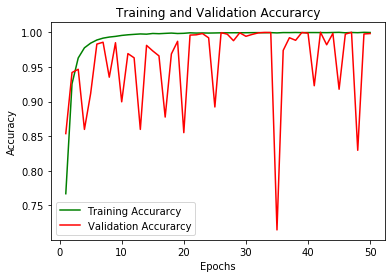

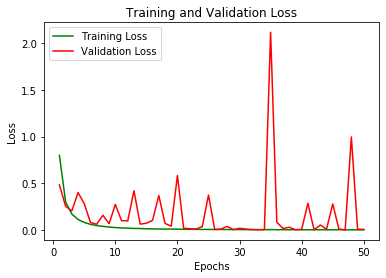

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
ycalculated = model.predict(np_valid_image_list)

In [34]:
print(np_valid_image_list)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.00784314 0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [35]:
yhat_classes =np.argmax(ycalculated,axis=1)

In [36]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)


In [37]:
print(label_binarizer.classes_)

['Amphidinium' 'Chatonella' 'Cochlodinium' 'Gymnodinium catenatum'
 'Karenia' 'Lyngbya' 'Ostreopsis' 'Prymnesium parvum' 'Pseudo-nitzschia'
 'Tolypothrix conglutinata']


In [38]:
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
#import seaborn as sns
#y_pred=model.predict_classes(np_valid_image_list)
#con_mat = tf.math.confusion_matrix(labels=y_true, predictions=ycalculated).numpy()
#matrix = confusion_matrix(rounded_labels,yhat_classes)
#y_pred=model.predict(np.array(val_image_list))
#yhat_classes = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#rounded_labels = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
cm =confusion_matrix(rounded_labels,yhat_classes)  

#matrix =confusion_matrix(bin_val_image_labels.argmax(axis=1), ycalculated)
print(cm)

[[2000    0    0    0    0    0    0    0    0    0]
 [   0 2000    0    0    0    0    0    0    0    0]
 [   0    0 2000    0    0    0    0    0    0    0]
 [   0    0    0 2000    0    0    0    0    0    0]
 [  25    1    1    0 1969    0    0    0    4    0]
 [   0    0    0    0    0 2000    0    0    0    0]
 [   1    6    0    0    0    0 1993    0    0    0]
 [   0    0    0    0    0    0    0 2000    0    0]
 [   0    0    0    0    0    0    0    0 2000    0]
 [   0    0    0    0    0    0    0    0    0 2000]]


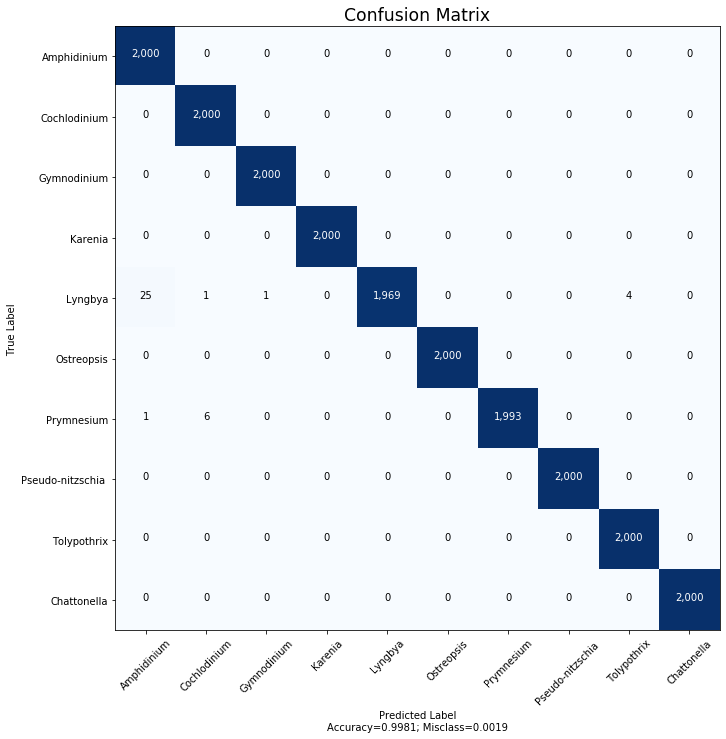

In [44]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm, 
                      normalize = False,
                      target_names=['Amphidinium','Cochlodinium','Gymnodinium','Karenia','Lyngbya',
 'Ostreopsis','Prymnesium','Pseudo-nitzschia ',
 'Tolypothrix','Chattonella'],
                      title        = "Confusion Matrix")

In [40]:
from sklearn.metrics import accuracy_score,classification_report 
target_names =['Amphidinium','Cochlodinium','Gymnodinium','Karenia','Lyngbya',
 'Ostreopsis','Prymnesium','Pseudo-nitzschia ',
 'Tolypothrix','Chattonella']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

                   precision    recall  f1-score   support

      Amphidinium       0.99      1.00      0.99      2000
     Cochlodinium       1.00      1.00      1.00      2000
      Gymnodinium       1.00      1.00      1.00      2000
          Karenia       1.00      1.00      1.00      2000
          Lyngbya       1.00      0.98      0.99      2000
       Ostreopsis       1.00      1.00      1.00      2000
       Prymnesium       1.00      1.00      1.00      2000
Pseudo-nitzschia        1.00      1.00      1.00      2000
      Tolypothrix       1.00      1.00      1.00      2000
      Chattonella       1.00      1.00      1.00      2000

         accuracy                           1.00     20000
        macro avg       1.00      1.00      1.00     20000
     weighted avg       1.00      1.00      1.00     20000



In [41]:
class_to_label_map={0:'Amphidinium',1:'Cochlodinium',2:'Gymnodinium',3:'Karenia',4:'Lyngbya',5:
 'Ostreopsis',6:'Prymnesium parvum',7:'Pseudo-nitzschia',8:
 'Tolypothrix-conglutinata',9:'chatonella'}

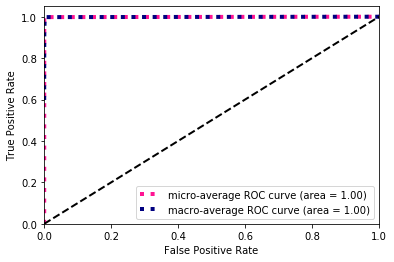

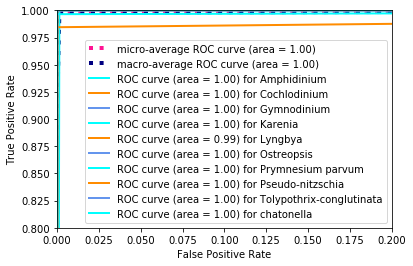

In [46]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =10

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()

